In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def make_ax(): #axisの準備
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)                  
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    return ax

def draw_trajectory(xs, ax): #軌跡の描画
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax): #センサ値の描画
    for s in range(len(xs)):
        if s not in zlist:
            continue
            
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi, _ = obs[1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax): 
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1] ,e.x2[1]], color="red", alpha=0.5)

def draw(xs, zlist, edges): #edges追加
    ax = make_ax()
    draw_trajectory(xs, ax)
    draw_observations(xs, zlist, ax)
 #   draw_edges(edges, ax)
    plt.show()

In [3]:
def read_data():#データの読み込み
    hat_xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
    zlist = {} #センサ値のデータ（ステップ数をキーにして、さらにその中にランドマークのIDとセンサ値をタプルで保存）

    with open("log.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": #姿勢のレコードの場合
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": #センサ値のレコードの場合
                if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
                
        return hat_xs, zlist

In [4]:
class Edge: ###graphbasedslam4edge
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]): #sensor_noise_rate追加
        assert z1[0] == z2[0] #ランドマークのIDが違ったら処理を止める
            
        self.landmark_id = z1[0]
        self.t1, self.t2 = t1, t2                   #時刻の記録
        self.x1, self.x2 = xs[t1], xs[t2]    #各時刻の姿勢
        self.z1, self.z2 = z1[1], z2[1]     #各時刻のセンサ値
        
        ##精度行列の作成##
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        s1 = math.sin(self.x1[2] + self.z1[1])
        c1 = math.cos(self.x1[2] + self.z1[1])
        R1 = - np.array([[c1, -self.z1[0]*s1,  0],
                                     [s1,   self.z1[0]*c1, 0],
                                   [   0,                      1, -1]])
        B1 = - np.array([[1, 0, -self.z1[0]*s1], #追加
                                    [0, 1, self.z1[0]*c1],
                                    [0, 0,                       1]])
        
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        R2 = np.array([[c2, -self.z2[0]*s2, 0],
                                  [s2, self.z2[0]*c2,   0],
                                  [  0,                      1,  -1]])
        B2 = np.array([[1, 0,  -self.z2[0]*s2], #追加
                                   [0, 1,   self.z2[0]*c2],
                                    [0, 0,                        1]])
        
        self.Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        self.Omega = np.linalg.inv(self.Sigma)
        
        ##現状の誤差を計算##
        delta_psi = self.z2[2] - self.z1[2]
        delta_theta = self.x2[2] - self.x1[2]
        while delta_psi > math.pi: delta_psi -= 2*math.pi
        while delta_psi < -math.pi: delta_psi += 2*math.pi
        while delta_theta > math.pi: delta_theta-= 2*math.pi
        while delta_theta < -math.pi: delta_theta += 2*math.pi
            
        hat_e = np.array([
            self.x2[0] - self.x1[0] + self.z2[0]*c2 - self.z1[0]*c1, 
            self.x2[1] - self.x1[1] + self.z2[0]*s2 - self.z1[0]*s1,
            delta_theta - self.z1[1] + self.z2[1] - delta_psi
        ])
        
        ##情報行列に足す各部分を計算##
        self.omega_upperleft = B1.T.dot(self.Omega).dot(B1)
        self.omega_upperright = B1.T.dot(self.Omega).dot(B2)
        self.omega_bottomleft = B2.T.dot(self.Omega).dot(B1)
        self.omega_bottomright = B2.T.dot(self.Omega).dot(B2)
        
        ##係数ベクトルに足す各部分を計算##
        self.xi_upper = - B1.T.dot(self.Omega).dot(hat_e)
        self.xi_bottom = - B2.T.dot(self.Omega).dot(hat_e)
        
    def __str__(self): #Omega追加
        return "landmark:{}, x1:{}, x2:{}, z1:{}, z2:{}, \nΣ:{}".format(self.landmark_id, self.x1, self.x2, self.z1, self.z2, self.Sigma) 

In [5]:
import itertools 
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {} #ランドマークのIDをキーにして観測された時刻とセンサ値を記録 

    for step in zlist:           #キーを時刻からランドマークのIDへ
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2)) #時刻のペアを作成
        edges += [Edge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
        
    return edges

In [6]:
def add_edge(edge, Omega, xi):
    f1, f2 = edge.t1*3, edge.t2*3
    t1 ,t2 = f1 + 3, f2 + 3
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom

<IPython.core.display.Javascript object>


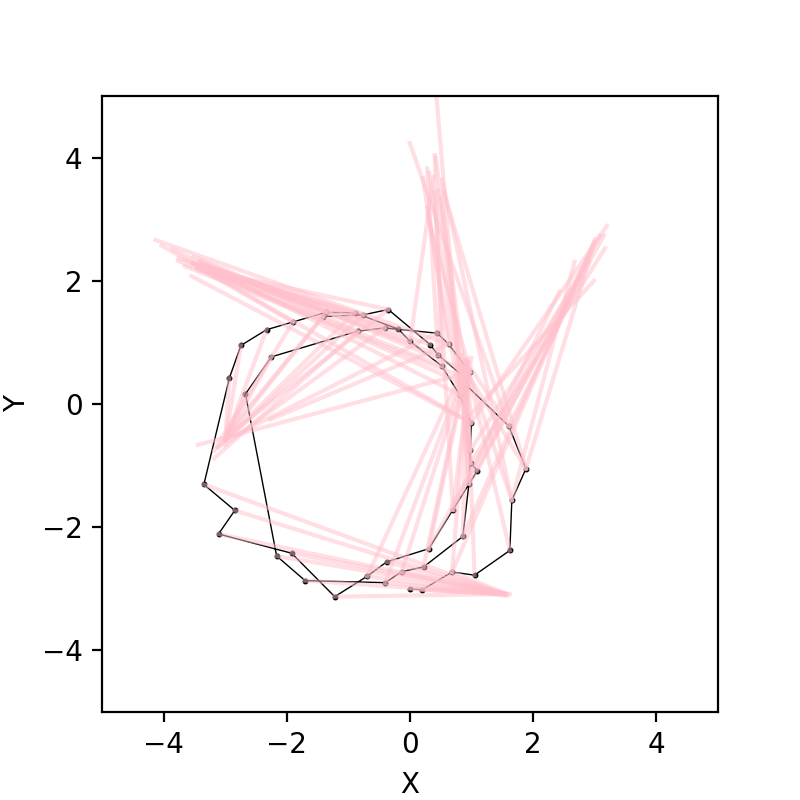

In [7]:
hat_xs, zlist = read_data() ###graphbasedslam4draw

for j in range(10):
    edges = make_edges(hat_xs, zlist)

    dim = len(hat_xs)*3
    Omega = np.zeros((dim, dim))
    xi = np.zeros(dim)

    Omega[0:3, 0:3] += np.eye(3)*1000000

    for e in edges:
        add_edge(e, Omega, xi)

    delta_xs = np.linalg.inv(Omega).dot(xi)
    for i in range(len(hat_xs)):
        a = hat_xs[i]
        a[0] += delta_xs[i*3]
        a[1] += delta_xs[i*3+1]
        a[2] += delta_xs[i*3+2]

draw(hat_xs, zlist, edges)

In [8]:
for e in edges:
    print(e)

landmark:1, x1:[ 6.56832361e-18 -3.00000000e+00  1.82314315e-04], x2:[ 0.19857962 -3.01565274  0.34510104], z1:[ 1.5344624  -0.06176764  3.12583722], z2:[ 1.33725076 -0.39713529  3.12499874], 
Σ:[[ 0.08096399 -0.00406091  0.00040989]
 [-0.00406091  0.01059221  0.00716749]
 [ 0.00040989  0.00716749  0.01      ]]
landmark:1, x1:[ 6.56832361e-18 -3.00000000e+00  1.82314315e-04], x2:[ 0.68303831 -2.72777308  0.61654403], z1:[ 1.5344624  -0.06176764  3.12583722], z2:[ 0.95563102 -0.99803052  2.78245084], 
Σ:[[ 0.06173254 -0.00786925  0.00112548]
 [-0.00786925  0.01048596  0.00604627]
 [ 0.00112548  0.00604627  0.01      ]]
landmark:1, x1:[ 6.56832361e-18 -3.00000000e+00  1.82314315e-04], x2:[-2.16486919 -2.46824607  5.38535524], z1:[ 1.5344624  -0.06176764  3.12583722], z2:[3.74838781 0.7321795  3.01154815], 
Σ:[[ 0.31485584 -0.04153944  0.00178097]
 [-0.04153944  0.04769435  0.01307164]
 [ 0.00178097  0.01307164  0.01      ]]
landmark:1, x1:[ 6.56832361e-18 -3.00000000e+00  1.82314315e-04]

 [-0.01237672  0.00376759  0.01      ]]
landmark:4, x1:[ 0.98050617 -0.74989043  7.75059753], x2:[ 0.30632522 -2.34895704 13.32755167], z1:[ 1.47023751  0.17383389 -1.45217243], z2:[ 2.91660733  0.60092054 -1.69414112], 
Σ:[[ 0.0330938   0.02687618 -0.01079987]
 [ 0.02687618  0.20267335  0.00125119]
 [-0.01079987  0.00125119  0.01      ]]
landmark:4, x1:[ 0.98050617 -0.74989043  7.75059753], x2:[ 0.69596103 -1.71789461 13.60605028], z1:[ 1.47023751  0.17383389 -1.45217243], z2:[ 2.48529109  0.41113314 -1.55568602], 
Σ:[[ 0.02254071  0.00994658 -0.00983507]
 [ 0.00994658  0.16173506  0.0004843 ]
 [-0.00983507  0.0004843   0.01      ]]
landmark:4, x1:[ 0.98050617 -0.74989043  7.75059753], x2:[ 0.98427521 -0.95893528 14.04699403], z1:[ 1.47023751  0.17383389 -1.45217243], z2:[ 1.75433587  0.17283919 -1.44982668], 
Σ:[[ 0.01364117 -0.00693235 -0.0080373 ]
 [-0.00693235  0.1021472  -0.00062143]
 [-0.0080373  -0.00062143  0.01      ]]
landmark:4, x1:[ 0.98050617 -0.74989043  7.75059753], x2:

landmark:0, x1:[-0.35198969  1.53364864 15.49631748], x2:[-0.75650461  1.44796835 15.62849859], z1:[ 2.95115307e+00 -2.75219286e-03 -8.75287469e-02], z2:[ 3.13724294 -0.21696718 -0.1792139 ], 
Σ:[[ 0.34252035 -0.07795901 -0.00385967]
 [-0.07795901  0.06746996 -0.01471028]
 [-0.00385967 -0.01471028  0.01      ]]
landmark:0, x1:[-0.35198969  1.53364864 15.49631748], x2:[-1.41143673  1.41955854 15.97347772], z1:[ 2.95115307e+00 -2.75219286e-03 -8.75287469e-02], z2:[ 2.52257664 -0.63053975 -0.26592529], 
Σ:[[ 0.27482715 -0.06722905 -0.00381998]
 [-0.06722905  0.05827946 -0.01310019]
 [-0.00381998 -0.01310019  0.01      ]]
landmark:0, x1:[-0.75650461  1.44796835 15.62849859], x2:[-1.41143673  1.41955854 15.97347772], z1:[ 3.13724294 -0.21696718 -0.1792139 ], z2:[ 2.52257664 -0.63053975 -0.26592529], 
Σ:[[ 0.28941664 -0.08328686 -0.00454129]
 [-0.08328686  0.06872902 -0.0133923 ]
 [-0.00454129 -0.0133923   0.01      ]]
landmark:5, x1:[0.97557917 0.51617712 2.38689222], x2:[0.62593653 0.97107

In [9]:
Omega

array([[ 1.00010279e+06,  1.25579380e+02,  7.07700054e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.25579380e+02,  1.00113164e+06,  7.10702771e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.07700054e+01,  7.10702771e+02,  1.00182510e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         6.15335815e+02, -1.05543077e+02,  4.76313601e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.05543077e+02,  1.01867510e+03, -1.33475533e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.76313601e+02, -1.33475533e+03,  5.54954394e+03]])